In [1]:
import pandas as pd
import numpy as np
import ast
from matplotlib import pyplot as plt
import sys
sys.path.append('../src/')
import data_layer


In [2]:
from tueplots import bundles
plt.rcParams.update(bundles.icml2022())

In [3]:
MIN_OCCURENCES=5

In [14]:
df_wiki = pd.read_csv("../dat/wiki/graph.csv")
df_llm = pd.read_json("../dat/llm/graph.json")
df_textbook = pd.read_json("../dat/textbooks/graph.json").iloc[:,[0,3]]
df_wiki.dep_articles = [ast.literal_eval(deps) for deps in (df_wiki.dep_articles)]

### 0. Descriptive Statistics for Graphs

In [15]:
def get_num_of_all_concepts(df):
    concepts = df.concept.to_list()
    deps = [dep for deps in df.dep_articles for dep in deps]
    all_concepts = set(concepts + deps)
    return len(all_concepts)

print("Total number of concepts and dependencies:")
print("Textbook: ", get_num_of_all_concepts(df_textbook))
print("Wikipedia: ", get_num_of_all_concepts(df_wiki))
print("LLM: ", get_num_of_all_concepts(df_llm))

Total number of concepts and dependencies:
Textbook:  1914
Wikipedia:  3041
LLM:  1823


In [18]:
print("Total number of concepts only:")
print("Textbook: ", df_textbook.shape[0])
print("Wikipedia: ", df_wiki.shape[0])
print("LLM: ", df_llm.shape[0])

Total number of concepts only:
Textbook:  1464
Wikipedia:  1464
LLM:  1464


In [19]:
def get_average_num_of_deps(deps):
    return np.mean([len(dep) for dep in deps])

print("Average Number of Dependencies  per Concept:")
print("Textbook: ", get_average_num_of_deps(df_textbook.dep_articles))
print("Wikipedia: ", get_average_num_of_deps(df_wiki.dep_articles))
print("LLM: ", get_average_num_of_deps(df_llm.dep_articles))

Average Number of Dependencies  per Concept:
Textbook:  5.657103825136612
Wikipedia:  2.9057377049180326
LLM:  2.751366120218579


In [ ]:
# It is not possible to calculate the number of orders for the histogram!!!

# def check_dep(concept,d):
#     try:
#         deps=d[concept]
#         return deps
#     except:
#         pass
    

# def calc_levels(df):
#     d =  {concept:dep for concept,dep in zip (df.concept,df.dep_articles)} 
#     n_levels = 1
#     d_levels={}
#     for concept in list(d.keys())[:10]:
#         deps = check_dep(concept,d)
#         while deps:
#             n_levels+=1
#             deps = set([i for dep in deps  if check_dep(dep,d) for i in check_dep(dep,d)])  
#         d_levels[concept] = n_levels-1
#         print(d_levels)
#     return d_levels

# calc_levels(df_textbook)

In [32]:
def create_adj(df):
    df_long = df.loc[:,["concept","dep_articles"]].explode('dep_articles')
    df_pairs = df_long.groupby(['concept', 'dep_articles']).size().reset_index(name='count')
    adj_matrix = df_pairs.pivot_table(index='concept', columns='dep_articles', values='count', fill_value=0)
    return adj_matrix

create_adj(df_wiki)

dep_articles,#CITEREFFrobenius1912,#CITEREFHoene-Wroński1812,#CITEREFJohnson1955,#CITEREFMuir1882,#CITEREFPerron1907,#Notation and terminology,#Source and target languages,%C4%80ryabha%E1%B9%ADa%27s sine table,%CE%99,0,...,Worldview,Writing system#Directionality,X,X chromosome,X-ray computed tomography,Zenith,Zero,Zero element,Zero of a function,Zero vector
concept,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012 in science,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2D computer graphics,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ALGOL 58,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zero of a function,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zero-dimensional space,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zero-product property,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### 1. Baseline Consistency

In [20]:
df_textbook.columns=['concept','dep_articles_textbook']

In [11]:
_, _, df_count = data_layer.read_index_and_wiki_concepts(include_counts=True)

In [16]:
deps = pd.merge(df_wiki[['concept', 'dep_articles']], df_llm[['concept', 'dep_articles']], on="concept", suffixes=('_wiki', '_llm'))
deps = pd.merge(deps[['concept', 'dep_articles_wiki', 'dep_articles_llm']], df_textbook[['concept', 'dep_articles_textbook']], on="concept")
deps = pd.merge(deps, df_count, on="concept")

In [13]:
def get_number_common_concepts(concept, first, second):
    deps1 = set(first)
    deps2 = set(second)
    if len(deps1.intersection(deps2)):
        #print(f"{concept}: {first} vs {second}")
        pass
    return len(deps1.intersection(deps2))

deps['num_common_tb_wiki'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r.dep_articles_textbook, r.dep_articles_wiki), axis=1)
deps['num_common_tb_llm'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r.dep_articles_textbook, r.dep_articles_llm), axis=1)
deps['num_common_llm_wiki'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r.dep_articles_llm, r.dep_articles_wiki), axis=1)

In [33]:
filter = deps['count']>=MIN_OCCURENCES

In [20]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


fig = make_subplots(rows=1, cols=3,subplot_titles=("Textbooks and Wikipedia","Textbooks and T0pp", "T0pp and Wikipedia"))

trace0 = go.Histogram(x=deps.loc[filter,'num_common_tb_wiki'],texttemplate="%{y}",marker_color = "#BC602D",xbins_size=0.5)
trace1 = go.Histogram(x=deps.loc[filter,'num_common_tb_llm'],texttemplate="%{y}",marker_color = "#BC602D",xbins_size=0.5)
trace2 = go.Histogram(x=deps.loc[filter,'num_common_llm_wiki'],texttemplate="%{y}",marker_color = "#BC602D",xbins_size=0.5)

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 1, 3)

#fig.update_xaxes(title_text="# of common direct dependencies",  row=1, col=1)
fig.update_yaxes(title_text="Frequency", row=1, col=1)
fig.update_xaxes(title_text="# of common direct dependencies",  row=1, col=2)
#fig.update_xaxes(title_text="# of common direct dependencies",  row=1, col=3)

fig.update_layout({
"plot_bgcolor": "rgba(0, 0, 0, 0)",
"paper_bgcolor": "rgba(0, 0, 0, 0)"
}, showlegend=False)

fig.show()

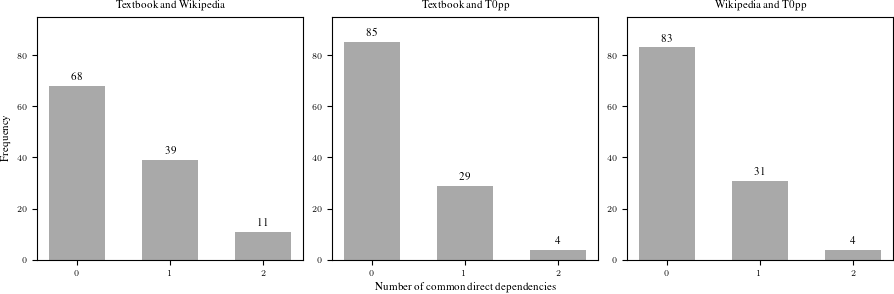

In [83]:
dep_freqs = deps.loc[filter]
dep_freqs = dep_freqs.iloc[:,-3:].apply(pd.Series.value_counts)

figs, ax = plt.subplots(1, 3, figsize=(9,3))

ax[0].set_title("Textbook and Wikipedia")
rects = ax[0].bar(dep_freqs.index,dep_freqs['num_common_tb_wiki'],width=0.6, color="darkgrey")
ax[0].bar_label(rects, padding=3)
ax[0].set_ylabel('Frequency')
ax[0].set_xticks(dep_freqs.index)
ax[0].set_ylim(0, 95)

ax[1].set_title("Textbook and T0pp")
rects = ax[1].bar(dep_freqs.index,dep_freqs['num_common_tb_llm'],width=0.6, color="darkgrey")
ax[1].bar_label(rects, padding=3)
ax[1].set_xticks(dep_freqs.index)
ax[1].set_ylim(0, 95)

ax[2].set_title("Wikipedia and T0pp")
rects = ax[2].bar(dep_freqs.index,dep_freqs['num_common_llm_wiki'],width=0.6, color="darkgrey")
ax[2].bar_label(rects, padding=3)
ax[2].set_xticks(dep_freqs.index)
ax[2].set_ylim(0, 95)

ax[1].set_xlabel('Number of common direct dependencies')
plt.show()

In [87]:
figs.savefig("../doc/img/comp_direct_deps.pdf", format="pdf")

### + 2nd level

In [84]:
def get_2leveldeps(dep_articles,colname):
    deps2lev = deps.loc[deps['concept'].isin(dep_articles),colname].to_list()
    if deps2lev:
        if isinstance(deps2lev[0],list):
            deps2_lev_flat=[dep for dep_list in deps2lev for dep in dep_list]
            return deps2_lev_flat + dep_articles
        else:    
            return list(set(deps2lev[0]+dep_articles))
    else:
        return dep_articles


deps['2levdeps_tb'] = deps['dep_articles_textbook'].apply(lambda x: get_2leveldeps(x,'dep_articles_textbook'))
deps['2levdeps_llm'] = deps['dep_articles_llm'].apply(lambda x: get_2leveldeps(x,'dep_articles_llm'))
deps['2levdeps_wiki'] = deps['dep_articles_wiki'].apply(lambda x: get_2leveldeps(x, 'dep_articles_wiki'))

deps['num_common_tb_wiki2'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r['2levdeps_tb'], r['2levdeps_wiki']), axis=1)
deps['num_common_tb_llm2'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r['2levdeps_tb'], r['2levdeps_llm']), axis=1)
deps['num_common_llm_wiki2'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r['2levdeps_llm'], r['2levdeps_wiki']), axis=1)

In [11]:
fig = make_subplots(rows=1, cols=3,subplot_titles=("Textbooks and Wikipedia","Textbooks and T0pp", "T0pp and Wikipedia"))

trace0 = go.Histogram(x=deps.loc[filter,'num_common_tb_wiki2'],texttemplate="%{y}",marker_color = "#BC602D",xbins_size=0.5)
trace1 = go.Histogram(x=deps.loc[filter,'num_common_tb_llm2'],texttemplate="%{y}",marker_color = "#BC602D",xbins_size=0.5)
trace2 = go.Histogram(x=deps.loc[filter,'num_common_llm_wiki2'],texttemplate="%{y}",marker_color = "#BC602D",xbins_size=0.5)

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 1, 3)

#fig.update_xaxes(title_text="# of common direct+2nd-level dependencies",  row=1, col=1)
fig.update_yaxes(title_text="Frequency", row=1, col=1)
fig.update_xaxes(title_text="# of common direct  and second-level dependencies",  row=1, col=2)
#fig.update_xaxes(title_text="# of common direct+2nd-level dependencies",  row=1, col=3)

fig.update_layout({
"plot_bgcolor": "rgba(0, 0, 0, 0)",
"paper_bgcolor": "rgba(0, 0, 0, 0)",
}, showlegend=False)

fig.show()

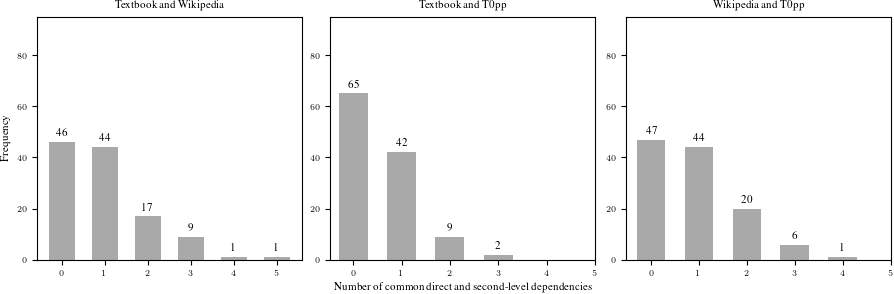

In [85]:
dep_freqs = deps.loc[filter]
dep_freqs = dep_freqs.iloc[:,-3:].apply(pd.Series.value_counts)

figs, ax = plt.subplots(1, 3, figsize=(9,3))

ax[0].set_title("Textbook and Wikipedia")
rects = ax[0].bar(dep_freqs.index,dep_freqs['num_common_tb_wiki2'],width=0.6, color="darkgrey")
ax[0].bar_label(rects, padding=3)
ax[0].set_ylabel('Frequency')
ax[0].set_xticks(dep_freqs.index)
ax[0].set_ylim(0, 95)

ax[1].set_title("Textbook and T0pp")
rects = ax[1].bar(dep_freqs.index,dep_freqs['num_common_tb_llm2'],width=0.6, color="darkgrey")
ax[1].bar_label(rects, padding=3)
ax[1].set_xticks(dep_freqs.index)
ax[1].set_ylim(0, 95)

ax[2].set_title("Wikipedia and T0pp")
rects = ax[2].bar(dep_freqs.index,dep_freqs['num_common_llm_wiki2'],width=0.6, color="darkgrey")
ax[2].bar_label(rects, padding=3)
ax[2].set_xticks(dep_freqs.index)
ax[2].set_ylim(0, 95)

ax[1].set_xlabel('Number of common direct  and second-level dependencies')
plt.show()

In [86]:
figs.savefig("../doc/img/comp_second_deps.pdf", format="pdf")

### Precision

In [21]:
_, _, df_count = data_layer.read_index_and_wiki_concepts(include_counts=True)

deps = pd.merge(df_wiki[['concept', 'dep_articles']], df_llm[['concept', 'dep_articles']], on="concept", suffixes=('_wiki', '_llm'))
deps = pd.merge(deps[['concept', 'dep_articles_wiki', 'dep_articles_llm']], df_textbook[['concept', 'dep_articles_textbook']], on="concept")
deps = pd.merge(deps, df_count, on="concept")

In [22]:
deps

,concept,dep_articles_wiki,dep_articles_llm,dep_articles_textbook,count
0,Absolute value,"[Real number, Non-negative, Sign (mathematics)...","[Number, Concept]","[Differential equation, Real number, Equation,...",6
1,Adjoint,[],"[Function (mathematics), Combination, Function...","[Laplace expansion, Minor (linear algebra), Pr...",5
2,Adjugate matrix,"[Square matrix, Transpose, Cofactor matrix]","[Matrix (mathematics), Combination, Matrix (ma...","[Laplace expansion, Cofactor (biochemistry), P...",5
3,Affine space,"[Structure (mathematics), Euclidean space, Par...","[Space (mathematics), Pattern, Point (geometry)]","[Stochastic matrix, Vector space, Linear subsp...",2
4,Affine transformation,"[Geometric transformation, Line (geometry), Pa...","[Transformation (function), Isometry, Shape]","[Field extension, Vector space]",9
...,...,...,...,...,...
1459,Vertical bar,[Glyph],"[Line (geometry), Axis, Rotation (mathematics)]","[Formula, Conic section, Equation, Slope, Line...",1
1460,Vertical line test,"[Curve (mathematics), Graph of a function, Fun...","[SAT, Variance, Equality (mathematics)]","[Function (mathematics), African Americans, Gr...",1
1461,Vertical tangent,"[Calculus, Tangent, Vertical direction]","[Line (geometry), Tangent, Line segment]","[Function (mathematics), Asymptote, Infinity, ...",1
1462,Zero of a function,"[Real number, Complex number, Vector-valued fu...","[Graph (discrete mathematics), Point (geometry...","[Exponentiation, Polynomial, Radius, Infinity,...",1


In [23]:
def get_precision_base(concept, first, second):
    deps1 = set(first)
    deps2 = set(second)
    if len(deps1.intersection(deps2)):
        #print(f"{concept}: {first} vs {second}")
        pass
    return len(deps1.intersection(deps2))

deps['num_common_tb_wiki'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r.dep_articles_textbook, r.dep_articles_wiki), axis=1)
deps['num_common_tb_llm'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r.dep_articles_textbook, r.dep_articles_llm), axis=1)
deps['num_common_llm_wiki'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r.dep_articles_llm, r.dep_articles_wiki), axis=1)

In [31]:
deps["num_wiki"] = deps.dep_articles_wiki.apply(lambda x: len(x))
deps["num_llm"] = deps.dep_articles_llm.apply(lambda x: len(x))
deps["num_textbook"] = deps.dep_articles_textbook.apply(lambda x: len(x))

deps["precision_tb_wiki_wiki"] = deps['num_common_tb_wiki']/deps["num_wiki"] 
deps["precision_tb_wiki_tb"] = deps['num_common_tb_wiki']/deps["num_textbook"] 
deps["precision_tb_wiki_all"] = deps['num_common_tb_wiki']/(deps["num_textbook"]+deps["num_wiki"]) 

deps["precision_tb_llm_tb"] = deps['num_common_tb_llm']/deps["num_textbook"] 
deps["precision_tb_llm_llm"] = deps['num_common_tb_llm']/deps["num_llm"] 
deps["precision_tb_llm_all"] = deps['num_common_tb_llm']/(deps["num_textbook"]+deps["num_llm"]) 

deps["precision_llm_wiki_wiki"] = deps['num_common_llm_wiki']/deps["num_wiki"] 
deps["precision_llm_wiki_llm"] = deps['num_common_llm_wiki']/deps["num_llm"] 
deps["precision_llm_wiki_all"] = deps['num_common_llm_wiki']/(deps["num_llm"]+deps["num_wiki"]) 

deps = deps.fillna(0)

In [32]:
deps.head()

,concept,dep_articles_wiki,dep_articles_llm,dep_articles_textbook,count,num_common_tb_wiki,num_common_tb_llm,num_common_llm_wiki,num_wiki,num_llm,num_textbook,precision_tb_wiki_wiki,precision_tb_wiki_tb,precision_tb_wiki_all,precision_tb_llm_tb,precision_tb_llm_llm,precision_tb_llm_all,precision_llm_wiki_wiki,precision_llm_wiki_llm,precision_llm_wiki_all
0,Absolute value,"[Real number, Non-negative, Sign (mathematics)...","[Number, Concept]","[Differential equation, Real number, Equation,...",6,1,0,0,4,2,7,0.25,0.142857,0.090909,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,Adjoint,[],"[Function (mathematics), Combination, Function...","[Laplace expansion, Minor (linear algebra), Pr...",5,0,0,0,0,3,6,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,Adjugate matrix,"[Square matrix, Transpose, Cofactor matrix]","[Matrix (mathematics), Combination, Matrix (ma...","[Laplace expansion, Cofactor (biochemistry), P...",5,0,1,0,3,3,6,0.00,0.000000,0.000000,0.166667,0.333333,0.111111,0.0,0.0,0.0
3,Affine space,"[Structure (mathematics), Euclidean space, Par...","[Space (mathematics), Pattern, Point (geometry)]","[Stochastic matrix, Vector space, Linear subsp...",2,0,0,0,4,3,6,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,Affine transformation,"[Geometric transformation, Line (geometry), Pa...","[Transformation (function), Isometry, Shape]","[Field extension, Vector space]",9,0,0,0,5,3,2,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


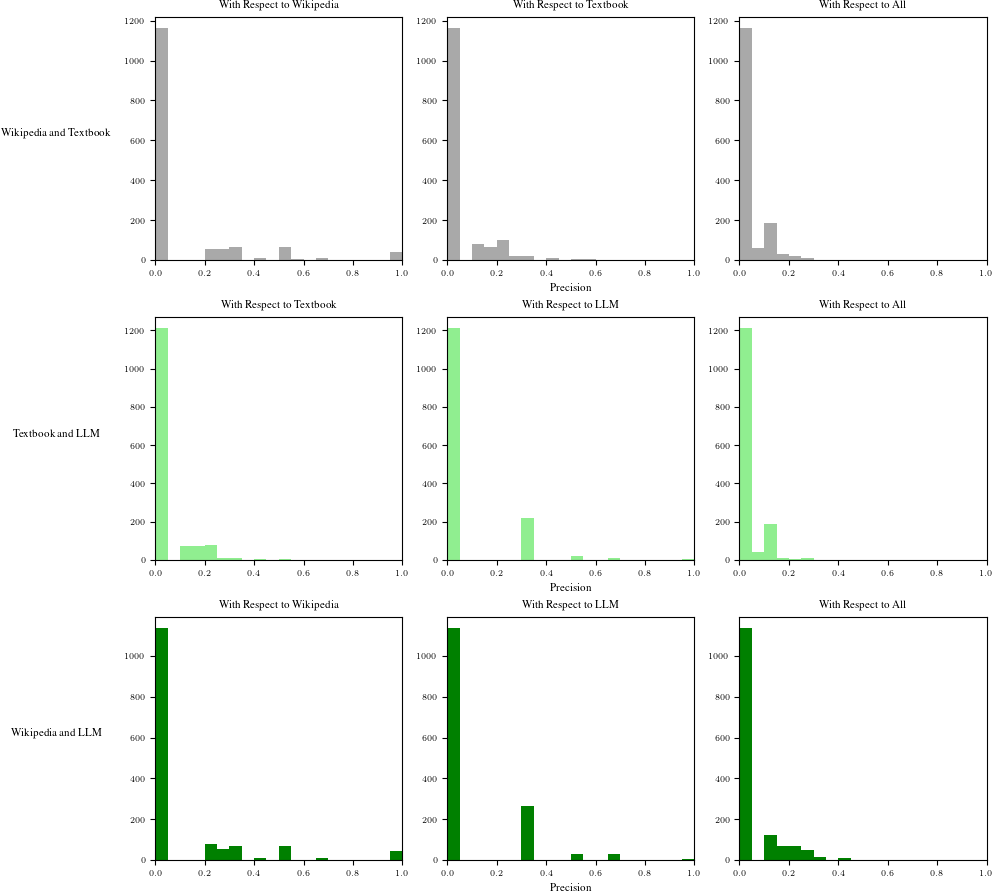

In [71]:
figs, ax = plt.subplots(3, 3, figsize=(10,9))

ax[0,0].set_title("With Respect to Wikipedia")
ax[0,0].hist(deps['precision_tb_wiki_wiki'],bins=20, range = (0,1),color="darkgrey")
ax[0,0].set_xlim(0, 1)
ax[0,0].set_ylabel('Wikipedia and Textbook', rotation=0, labelpad=50)

ax[0,1].set_title("With Respect to Textbook")
ax[0,1].hist(deps['precision_tb_wiki_tb'],bins=20, range = (0,1), color="darkgrey")
ax[0,1].set_xlim(0, 1)

ax[0,2].set_title("With Respect to All")
ax[0,2].hist(deps['precision_tb_wiki_all'],bins=20, range = (0,1), color="darkgrey")
ax[0,2].set_xlim(0, 1)


ax[1,0].set_title("With Respect to Textbook")
ax[1,0].hist(deps['precision_tb_llm_tb'],bins=20, range = (0,1),color="lightgreen")
ax[1,0].set_xlim(0, 1)

ax[1,0].set_ylabel('Textbook and LLM', rotation=0, labelpad=50)

ax[1,1].set_title("With Respect to LLM")
ax[1,1].hist(deps['precision_tb_llm_llm'],bins=20, range = (0,1), color="lightgreen")
ax[1,1].set_xlim(0, 1)

ax[1,2].set_title("With Respect to All")
ax[1,2].hist(deps['precision_tb_llm_all'],bins=20, range = (0,1), color="lightgreen")
ax[1,2].set_xlim(0, 1)


ax[2,0].set_title("With Respect to Wikipedia")
ax[2,0].hist(deps['precision_llm_wiki_wiki'],bins=20, range = (0,1),color="green")
ax[2,0].set_xlim(0, 1)
ax[2,0].set_ylabel('Wikipedia and LLM', rotation=0, labelpad=50)

ax[2,1].set_title("With Respect to LLM")
ax[2,1].hist(deps['precision_llm_wiki_llm'],bins=20, range = (0,1), color="green")
ax[2,1].set_xlim(0, 1)

ax[2,2].set_title("With Respect to All")
ax[2,2].hist(deps['precision_llm_wiki_all'],bins=20, range = (0,1), color="green")
ax[2,2].set_xlim(0, 1)

ax[0,1].set_xlabel('Precision')
ax[1,1].set_xlabel('Precision')
ax[2,1].set_xlabel('Precision')

plt.show()

In [72]:
figs.savefig("../doc/img/precision_deps.pdf", format="pdf")